In [76]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [77]:
def read_data(data_path, data_type):
    """
    Read data from the specified path based on the data type.

    Parameters:
    - data_path: str
        Path to the directory containing the data.
    - data_type: str
        Type of data to read ('before', 'after', or 'label').

    Returns:
    - data: list of numpy.ndarray or None
        List of images read from the specified path. Returns None if data_type is invalid.

    Note:
    This function reads images from the specified directory based on the data type provided.
    It reads images from subdirectories 'A' for 'before' data, 'B' for 'after' data, and 'label'
    for label data.

    Example:
    data_path = 'data'
    data_type = 'before'
    before_images = read_data(data_path, data_type)
    """

    if data_type == 'before':
        data_path = os.path.join(data_path, 'A')
    elif data_type == 'after':
        data_path = os.path.join(data_path, 'B')
    elif data_type == 'label':
        data_path = os.path.join(data_path, 'label')
    else:
        print('data_type is not correct')
        return None

    data = []
    for file in os.listdir(data_path):
        img = cv2.imread(os.path.join(data_path, file))
        data.append(img)
    return data


In [78]:
def display_images(before, after, labels):
    """
    Display images representing the before state, after state, and labels.

    Parameters:
    - before: numpy.ndarray
        Image representing the before state.
    - after: numpy.ndarray
        Image representing the after state.
    - labels: numpy.ndarray
        Array representing the labels.

    Returns:
    None

    Note:
    This function displays three images side by side using Matplotlib:
    - Before state image
    - After state image
    - Labels

    Example:
    before = np.array([[...]])
    after = np.array([[...]])
    labels = np.array([[...]])
    display_images(before, after, labels)
    """

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')
    plt.show()


In [79]:
def plot_row(images, titles):
    """
    Plot a row of images with corresponding titles.

    Parameters:
    - images: list of numpy.ndarray
        List of images to plot.
    - titles: list of str
        List of titles corresponding to each image.

    Returns:
    None

    Note:
    This function plots a row of images side by side with their corresponding titles.

    Example:
    images = [image1, image2, image3]
    titles = ['Title 1', 'Title 2', 'Title 3']
    plot_row(images, titles)
    """

    # Create subplots
    fig, ax = plt.subplots(1, len(images), figsize=(10, 20))

    # Plot the first image
    ax[0].imshow(images[0].astype("uint8"))
    ax[0].set_title(titles[0])
    ax[0].axis("off")

    # Plot the remaining images with titles
    for i in range(len(images) - 1):
        ax[i + 1].imshow(images[i + 1])
        ax[i + 1].set_title(titles[i + 1])
        ax[i + 1].axis("off")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


In [80]:
training_path = '../trainval/'

In [81]:
before_images = read_data(training_path,'before')
after_images = read_data(training_path, 'after')
labels = read_data(training_path,'label')

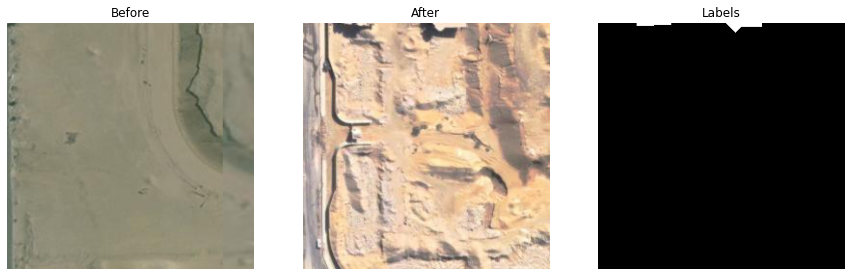

In [82]:
index = 0
# print first image in before_images, after_images, and labels in the same row
display_images(before_images[index], after_images[index], labels[index])

## PCA with Kmeans

In [83]:
def find_vector_set(diff_image, new_size):
    """
    Create a vector set from a difference image.

    Parameters:
    - diff_image: numpy.ndarray
        The difference image from which to create the vector set.
    - new_size: tuple
        A tuple containing the new size dimensions (height, width) of the image.

    Returns:
    - vector_set: numpy.ndarray
        A 2D array representing the vector set derived from the difference image.
    - mean_vec: numpy.ndarray
        A 1D array containing the mean vector computed from the vector set.

    Note:
    The function divides the new image size into non-overlapping blocks of size 5x5,
    and each block is flattened into a 1D array to form the feature vector. The function
    then computes the mean vector and performs mean normalization on the vector set.

    Example:
    diff_image = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
    new_size = (3, 5)
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    """

    # Initialize variables
    i = 0
    j = 0

    # Initialize the vector set with zeros
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25), 25))

    # Iterate over the vector set
    while i < vector_set.shape[0]:
        while j < new_size[1]:
            k = 0
            while k < new_size[0]:
                # Extract a 5x5 block from the difference image
                block = diff_image[j:j+5, k:k+5]
                
                # Flatten the block into a 1D feature vector
                feature = block.ravel()
                
                # Assign the feature vector to the current row of the vector set
                vector_set[i, :] = feature
                
                k += 5  # Move to the next block horizontally
            j += 5  # Move to the next block vertically
        i += 1  # Move to the next row in the vector set

    # Compute the mean vector across the vector set
    mean_vec = np.mean(vector_set, axis=0)

    # Mean normalization
    vector_set = vector_set - mean_vec

    return vector_set, mean_vec


In [84]:
def find_FVS(EVS, diff_image, mean_vec, new):
    """
    Find the Feature Vector Space (FVS) from Eigen Vector Space (EVS) and a difference image.

    Parameters:
    - EVS: numpy.ndarray
        Eigen Vector Space obtained from some previous computation.
    - diff_image: numpy.ndarray
        The difference image from which to extract features.
    - mean_vec: numpy.ndarray
        Mean vector computed from the vector set.
    - new: tuple
        A tuple containing the dimensions (height, width) of the new image.

    Returns:
    - FVS: numpy.ndarray
        The Feature Vector Space derived from the difference image and the Eigen Vector Space.

    Note:
    The function iterates over the difference image, extracting 5x5 blocks centered at each pixel,
    flattening them into feature vectors, and appending them to a feature vector set. The Feature Vector
    Space (FVS) is then computed by dot-producting this feature vector set with the Eigen Vector Space (EVS).
    Finally, mean normalization is applied to the FVS using the provided mean vector.

    Example:
    EVS = np.array([[0.1, 0.2], [0.3, 0.4]])
    diff_image = np.array([[1, 2, 3], [4, 5, 6]])
    mean_vec = np.array([0.5, 0.6])
    new = (2, 3)
    FVS = find_FVS(EVS, diff_image, mean_vec, new)
    """

    # Initialize variables
    i = 2
    feature_vector_set = []

    # Iterate over the difference image
    while i < new[1] - 2:
        j = 2
        while j < new[0] - 2:
            # Extract a 5x5 block from the difference image centered at (i,j)
            block = diff_image[i - 2:i + 3, j - 2:j + 3]
            
            # Flatten the block into a feature vector
            feature = block.flatten()
            
            # Append the feature vector to the feature vector set
            feature_vector_set.append(feature)
            j += 1
        i += 1

    # Compute the Feature Vector Space (FVS) by dot-producting the feature vector set with EVS
    FVS = np.dot(feature_vector_set, EVS)
    
    # Mean normalization of FVS
    FVS = FVS - mean_vec

    return FVS


In [85]:
def clustering(FVS, components, new):
    """
    Perform clustering on the Feature Vector Space (FVS) using K-Means algorithm.

    Parameters:
    - FVS: numpy.ndarray
        Feature Vector Space derived from the difference image and Eigen Vector Space.
    - components: int
        Number of clusters to form.
    - new: tuple
        A tuple containing the dimensions (height, width) of the new image.

    Returns:
    - least_index: int
        The index of the cluster with the least number of elements.
    - change_map: numpy.ndarray
        A 2D array representing the change map obtained from clustering.

    Note:
    The function utilizes the K-Means clustering algorithm to cluster the feature vectors
    in the Feature Vector Space (FVS) into 'components' clusters. It then identifies the cluster
    with the least number of elements and generates a change map by reshaping the cluster labels.

    Example:
    FVS = np.array([[0.1, 0.2], [0.3, 0.4]])
    components = 2
    new = (2, 2)
    least_index, change_map = clustering(FVS, components, new)
    """

    # Initialize KMeans clustering model
    kmeans = KMeans(components, verbose=0)
    
    # Fit KMeans model to the Feature Vector Space (FVS)
    kmeans.fit(FVS)
    
    # Predict cluster labels for the feature vectors
    output = kmeans.predict(FVS)
    
    # Count the occurrences of each cluster label
    count = Counter(output)
 
    # Find the index of the cluster with the least number of elements
    least_index = min(count, key=count.get)
    
    # Reshape the cluster labels into a change map
    change_map = np.reshape(output, (new[1] - 4, new[0] - 4))
    
    return least_index, change_map


In [86]:
# Define the output directory
out_dir = "output"

# Check if the output directory exists, if not, create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [87]:
def display_images(before, after, labels, predicted_label):
    """
    Display images representing the before state, after state, ground truth labels, and predicted labels.

    Args:
    - before: numpy.ndarray
        Image representing the before state.
    - after: numpy.ndarray
        Image representing the after state.
    - labels: numpy.ndarray
        Array representing the ground truth labels.
    - predicted_label: numpy.ndarray
        Array representing the predicted labels.

    Returns:
    None

    Note:
    This function displays four images side by side using Matplotlib:
    - Before state image
    - After state image
    - Ground truth labels
    - Predicted labels

    Example:
    before = np.array([[...]])
    after = np.array([[...]])
    labels = np.array([[...]])
    predicted_label = np.array([[...]])
    display_images(before, after, labels, predicted_label)
    """

    # Convert images to uint8
    before = before.astype(np.uint8)
    after = after.astype(np.uint8)
    labels = labels.astype(np.uint8)
    predicted_label = predicted_label.astype(np.uint8)

    # Create subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    # Display the before state image
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')
    
    # Display the after state image
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')
    
    # Display the ground truth labels
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')
    
    # Display the predicted labels
    axs[3].imshow(predicted_label, cmap='gray')
    axs[3].set_title('Predicted Labels')
    axs[3].axis('off')
    
    plt.show()


In [88]:
def increase_saturation(before_images, after_images, factor):
    """
    Increases the saturation of a list of images using the HSV color space.

    Args:
    - before_images: list of NumPy arrays
        List of images representing the before state (RGB).
    - after_images: list of NumPy arrays
        List of images representing the after state (RGB).
    - factor: float
        Factor to increase the saturation by.

    Returns:
    - preprocessed_images_A: list of NumPy arrays
        List of images with increased saturation representing the before state (RGB).
    - preprocessed_images_B: list of NumPy arrays
        List of images with increased saturation representing the after state (RGB).

    Note:
    This function iterates over the pairs of before and after images, converts them to the HSV color space,
    increases the saturation by the specified factor, and then converts them back to the RGB color space.
    Finally, the images are scaled to the range [0, 255] and returned as lists.

    Example:
    before_images = [image1_before, image2_before]
    after_images = [image1_after, image2_after]
    factor = 1.5
    enhanced_before_images, enhanced_after_images = increase_saturation(before_images, after_images, factor)
    """

    preprocessed_images_A = []
    preprocessed_images_B = []

    # Iterate over pairs of before and after images
    for image_A, image_B in zip(before_images, after_images):
        # Convert the images to the HSV color space
        hsv_image_A = color.rgb2hsv(image_A)
        hsv_image_B = color.rgb2hsv(image_B)

        # Increase the saturation by the specified factor
        hsv_image_A[:, :, 1] *= factor
        hsv_image_B[:, :, 1] *= factor

        # Convert back to the RGB color space
        enhanced_image_A = color.hsv2rgb(hsv_image_A)
        enhanced_image_B = color.hsv2rgb(hsv_image_B)

        # Scale the images to the range [0, 255]
        enhanced_image_A = (enhanced_image_A * 255).astype(np.uint8)
        enhanced_image_B = (enhanced_image_B * 255).astype(np.uint8)

        # Append the preprocessed images to the lists
        preprocessed_images_A.append(enhanced_image_A)
        preprocessed_images_B.append(enhanced_image_B)

    return preprocessed_images_A, preprocessed_images_B


In [89]:
def preprocess_images(before_images, after_images, gamma_values):
    """
    Preprocesses a list of before and after satellite images using gamma correction.

    Args:
    - before_images: List of NumPy arrays representing the before images (RGB).
    - after_images: List of NumPy arrays representing the after images (RGB).
    - gamma_values: List of gamma values to apply for gamma correction.

    Returns:
    - preprocessed_images_A: List of preprocessed before images.
    - preprocessed_images_B: List of preprocessed after images.

    Note:
    This function applies gamma correction to each pair of before and after images using
    the specified gamma values. It returns lists of preprocessed before and after images.

    Example:
    before_images = [image1_before, image2_before]
    after_images = [image1_after, image2_after]
    gamma_values = [1.1, 1.2]
    preprocessed_before, preprocessed_after = preprocess_images(before_images, after_images, gamma_values)
    """

    preprocessed_images_A = []
    preprocessed_images_B = []

    for gamma in gamma_values:
        for image_A, image_B in zip(before_images, after_images):

            # Gamma Correction
            corrected_image_A = exposure.adjust_gamma(image_A, gamma)
            corrected_image_B = exposure.adjust_gamma(image_B, gamma)
            
            # Append preprocessed images to the lists
            preprocessed_images_A.append(corrected_image_A)
            preprocessed_images_B.append(corrected_image_B)

    return preprocessed_images_A, preprocessed_images_B


In [90]:
def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) score between two binary masks.

    Args:
    - mask1: numpy.ndarray
        Binary mask representing the first object.
    - mask2: numpy.ndarray
        Binary mask representing the second object.

    Returns:
    - iou_score: float
        Intersection over Union (IoU) score between the two masks.

    Note:
    This function calculates the IoU score between two binary masks. IoU is computed
    as the ratio of the area of overlap between the masks to the area of their union.

    Example:
    mask1 = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    mask2 = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
    iou = calculate_iou(mask1, mask2)
    """

    # Compute the intersection and union of the masks
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    # Calculate the IoU score
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score


Jaccard index (IOU) for pair 0: 0.7185565046200743


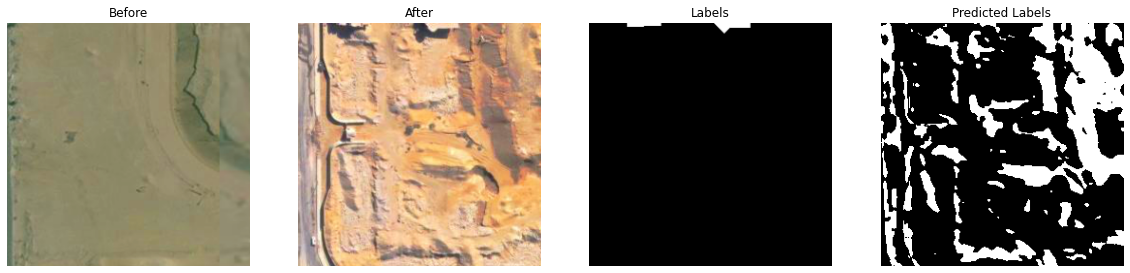

Jaccard index (IOU) for pair 1: 0.7772862073994846


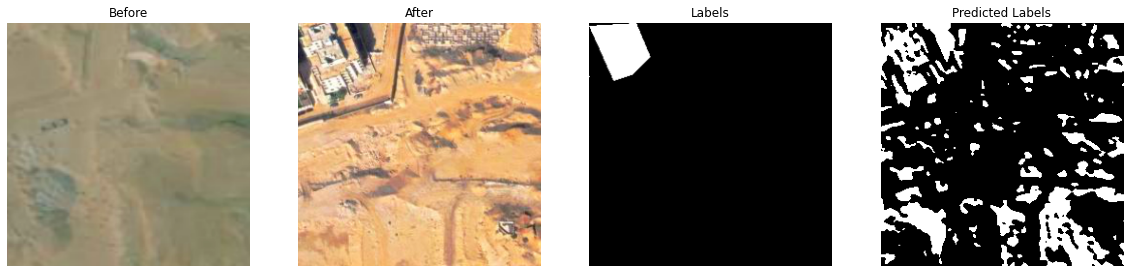

Jaccard index (IOU) for pair 2: 0.7365876684679992


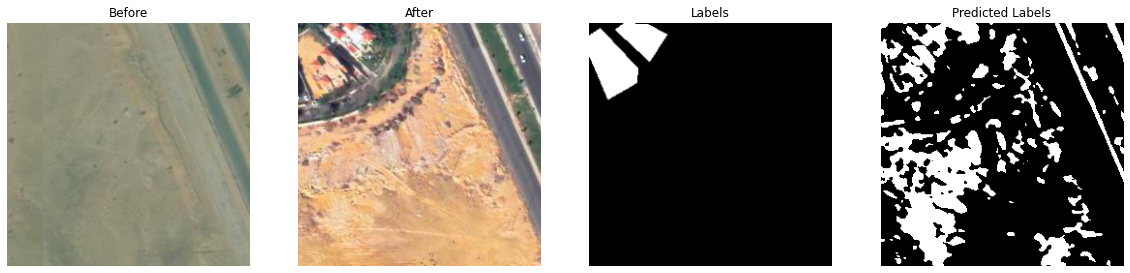

Jaccard index (IOU) for pair 3: 0.8024304945625269


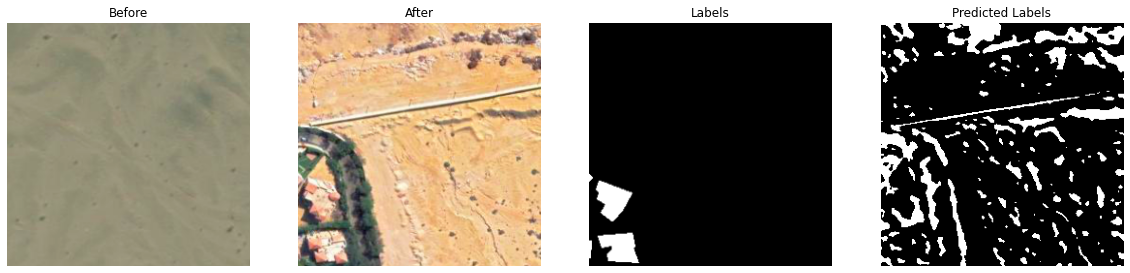

Jaccard index (IOU) for pair 4: 0.7645116744178664


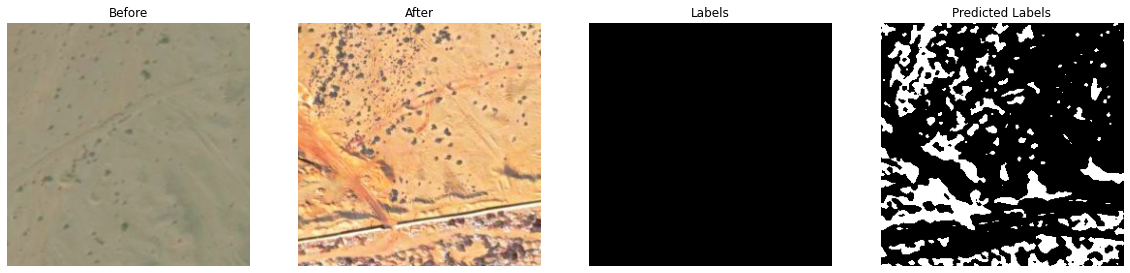

In [203]:
# Define the number of images to process
num_images = min(5, len(before_images))

# Define the preprocessing parameters
factor = 1.5
gamma_values = [1]

# Preprocess the last 5 images
before_images_last = before_images[num_images - 5:num_images]
after_images_last = after_images[num_images - 5:num_images]

before_images_processed, after_images_processed = increase_saturation(before_images_last, after_images_last, factor)
before_images_processed, after_images_processed = preprocess_images(before_images_processed, after_images_processed, gamma_values)

# Ensure that the processed images list contains the correct number of elements
num_processed_images = len(before_images_processed)
assert num_processed_images == 5, "Number of processed images should be 5"

# Iterate over pairs of images and apply change detection
iou_scores = []
for i in range(num_images - 5, num_images):
    # Apply change detection code here for each pair of images
    image1 = before_images_processed[i - (num_images - 5)]
    image2 = after_images_processed[i - (num_images - 5)]
    label = labels[i]

    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.mean(np.abs(image1_resized - image2_resized), axis=2)  # Average of RGB channels

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # Clustering
    least_index, change_map = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_map = change_map.astype(np.uint8)

    # Resize label to match the dimensions of change_map
    label_resized = cv2.resize(label, (change_map.shape[1], change_map.shape[0]))

    # Convert label to binary mask
    label_binary = label_resized > 0
    label_binary = cv2.cvtColor(label_binary.astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Invert the binary masks
    change_map_inverted = np.logical_not(change_map)
    label_binary_inverted = np.logical_not(label_binary)

    # Calculate Jaccard index (IOU) using built-in method
    intersection = np.logical_and(change_map_inverted, label_binary_inverted)
    union = np.logical_or(change_map_inverted, label_binary_inverted)
    iou = np.sum(intersection) / np.sum(union)

    # Append IOU score to the list
    iou_scores.append(iou)
    
    # Print Jaccard index for each pair
    print(f'Jaccard index (IOU) for pair {i}: {iou}')

    # Display images
    display_images(image1, image2, label_resized, change_map)


In [205]:
before_images2 = before_images[:5]
after_images2 = after_images[:5]
labels2 = labels[:5]

In [208]:
from sklearn.model_selection import train_test_split

# Define the preprocessing parameters
factor = 1.5
gamma_values = [1]

before_images_processed, after_images_processed = increase_saturation(before_images2, after_images2, factor)
before_images_processed, after_images_processed = preprocess_images(before_images_processed, after_images_processed, gamma_values)

# Ensure that the processed images list contains the correct number of elements
num_processed_images = len(before_images_processed)
assert num_processed_images == 5, "Number of processed images should be 5"

# Split data into training and testing sets
before_train, before_test, after_train, after_test, labels_train, labels_test = train_test_split(
    before_images_processed, after_images_processed, labels2, test_size=0.2, random_state=49)

# Ensure the corresponding labels match the images
assert len(before_train) == len(after_train) == len(labels_train)
assert len(before_test) == len(after_test) == len(labels_test)

# Initialize a list to store the IOU scores
iou_scores_train = []
iou_scores_test = []
# Now, iterate over the training and testing sets to perform change detection
for i in range(len(before_train)):
    image1 = before_train[i]
    image2 = after_train[i]
    label = labels_train[i]

    # Perform change detection on training data
    # (code block from the previous snippet)
    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.mean(np.abs(image1_resized - image2_resized), axis=2)  # Average of RGB channels

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # Clustering
    least_index, change_map = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_map = change_map.astype(np.uint8)

    # Resize label to match the dimensions of change_map
    label_resized = cv2.resize(label, (change_map.shape[1], change_map.shape[0]))

    # Convert label to binary mask
    label_binary = label_resized > 0
    label_binary = cv2.cvtColor(label_binary.astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Invert the binary masks
    change_map_inverted = np.logical_not(change_map)
    label_binary_inverted = np.logical_not(label_binary)

    # Calculate Jaccard index (IOU) using built-in method
    intersection = np.logical_and(change_map_inverted, label_binary_inverted)
    union = np.logical_or(change_map_inverted, label_binary_inverted)
    iou = np.sum(intersection) / np.sum(union)

    # Append IOU score to the list
    iou_scores_train.append(iou)
    
    # Print Jaccard index for each pair in training set
    print(f'Jaccard index (IOU) for pair {i} in Training: {iou}') 

    # Display images
    display_images(image1, image2, label_resized, change_map)

# Calculate the average IOU score for the training set
iou_train_avg = np.mean(iou_scores_train)
print(f'Average Jaccard index (IOU) for Training: {iou_train_avg}')

for i in range(len(before_test)):
    image1 = before_test[i]
    image2 = after_test[i]
    label = labels_test[i]

    # Perform change detection on testing data
    # (code block from the previous snippet)
    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.mean(np.abs(image1_resized - image2_resized), axis=2)  # Average of RGB channels

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # Clustering
    least_index, change_map = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_map = change_map.astype(np.uint8)

    # Resize label to match the dimensions of change_map
    label_resized = cv2.resize(label, (change_map.shape[1], change_map.shape[0]))

    # Convert label to binary mask
    label_binary = label_resized > 0
    label_binary = cv2.cvtColor(label_binary.astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Invert the binary masks
    change_map_inverted = np.logical_not(change_map)
    label_binary_inverted = np.logical_not(label_binary)

    # Calculate Jaccard index (IOU) using built-in method
    intersection = np.logical_and(change_map_inverted, label_binary_inverted)
    union = np.logical_or(change_map_inverted, label_binary_inverted)
    iou = np.sum(intersection) / np.sum(union)

    # Append IOU score to the list
    iou_scores_test.append(iou)
    
    # Print Jaccard index for each pair
    print(f'Jaccard index (IOU) for pair {i}: {iou}')

    # Display images
    display_images(image1, image2, label_resized, change_map)

# Calculate the average IOU score for the testing set
iou_test_avg = np.mean(iou_scores_test)
print(f'Average Jaccard index (IOU) for Testing: {iou_test_avg}')


KeyboardInterrupt: 

In [ ]:
# Define the number of images to process
num_images = len(before_images)

# Define the preprocessing parameters
factor = 1.5
gamma_values = [1.1]

# Preprocess all images
before_images_processed, after_images_processed = increase_saturation(before_images, after_images, factor)
before_images_processed, after_images_processed = preprocess_images(before_images_processed, after_images_processed, gamma_values)

# Ensure that the processed images list contains the correct number of elements
num_processed_images = len(before_images_processed)
assert num_processed_images == num_images, "Number of processed images should be equal to the number of input images"

# Ensure that the processed images list contains the correct number of elements
num_processed_images = len(before_images_processed)
assert num_processed_images == num_images, "Number of processed images should be equal to the number of input images"

# Iterate over pairs of images and apply change detection
iou_scores = []
for i in range(num_images):
    # Apply change detection code here for each pair of images
    image1 = before_images_processed[i]
    image2 = after_images_processed[i]

    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.mean(np.abs(image1_resized - image2_resized), axis=2)  # Average of RGB channels

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # Clustering
    least_index, change_map = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_map = change_map.astype(np.uint8)

    # Resize label to match the dimensions of change_map
    label_resized = cv2.resize(label, (change_map.shape[1], change_map.shape[0]))

    # Convert label to binary mask
    label_binary = label_resized > 0
    label_binary = cv2.cvtColor(label_binary.astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Invert the binary masks
    change_map_inverted = np.logical_not(change_map)
    label_binary_inverted = np.logical_not(label_binary)

    # Calculate Jaccard index (IOU) using built-in method
    intersection = np.logical_and(change_map_inverted, label_binary_inverted)
    union = np.logical_or(change_map_inverted, label_binary_inverted)
    iou = np.sum(intersection) / np.sum(union)

    # Append IOU score to the list
    iou_scores.append(iou)
    
    # Print Jaccard index for each pair
    print(f'Jaccard index (IOU) for pair {i}: {iou}')

In [ ]:
# Calculate mean Jaccard index
mean_iou = np.mean(iou_scores)
print(f'Mean Jaccard index (IOU): {mean_iou}')